<a href="https://colab.research.google.com/github/Kharazmigroup/forexprj/blob/main/RNN2Forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import all libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,RNN
from keras.layers import Dropout
import IPython
import IPython.display
from math import floor

In [ ]:
#set hyper parameters.there is a sequence. the network sees the input days and predicts the other days. seq_len is the sum of inputs and offsets.
seq_len = 3 # taken sequence length as 3
n_steps = seq_len - 1
n_neurons = 800
n_layers = 3
learning_rate = 0.000094
batch_size = 64
dropout_rate = 0.2
num_features = 6

For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

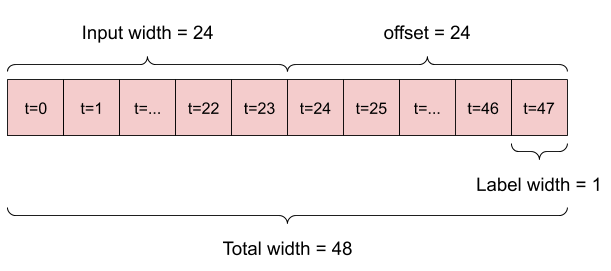

In [ ]:
#
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

In [ ]:
def spilitData(df_stock_norm):
  n = len(df_stock_norm)
  train_df = df_stock_norm[0:int(n*0.8)]
  val_df = df_stock_norm[int(n*0.8):int(n*0.9)]
  test_df = df_stock_norm[int(n*0.9):]

  num_features = df_stock_norm.shape[1]
  return train_df,val_df,test_df

In [ ]:
class WindowGenerator():

  def __init__(self,df,input_width, label_width, shift,label_columns=None):
    # Work out the label column indices.
    self.column_indices ={name: i for i, name in enumerate(df.columns)}
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def make_dataset(self, data):

  data = np.array(data, dtype=np.float32)

  ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size= batch_size)

  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    layers = [tf.keras.layers.SimpleRNNCell(units=n_neurons)
         for layer in range(n_layers)]
    self.lstm_cell = tf.keras.layers.StackedRNNCells(layers)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    #self.dense1 = tf.keras.layers.Dense(64, activation='relu')
    #self.dense2 = tf.keras.layers.Dense(32, activation='relu')
    #self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    #self.output_layer = tf.keras.layers.Dense(num_features, activation='linear')
    self.dense = tf.keras.layers.Dense(num_features,activation = 'relu')

In [ ]:
feedback_model = FeedBack(units=n_neurons, out_steps = n_steps)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)
  # predictions.shape => (batch, features)
  prediction = self.dense(x)

  return prediction, state

FeedBack.warmup = warmup

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                          training=training)
    if training:
      x = self.dropout(x)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
#MAX_EPOCHS = 150

def compile_and_fit(model, window,epoch, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=epoch,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
 def get_input_Labels(ds):
  ds_inputs = []
  ds_labels = []
  for inputs, labels in ds:
      ds_inputs.append(inputs.numpy())
      ds_labels.append(labels.numpy())
  batch_input = []
  batch_labels = []
  for i in range(len(ds_labels)):
    for j in range(len(ds_labels[i])):
      batch_labels.append(ds_labels[i][j])
      batch_input.append(ds_inputs[i][j])
  return np.array(batch_input),np.array(batch_labels)

In [ ]:
def plot_target_predict(test_labels,predictions):
  # ploting the graph
  comp = pd.DataFrame({'Column1':test_labels[:,-1,:][:,3],'Column2':predictions[:,-1,:][:,3]})
  plt.figure(figsize=(20,5))
  plt.plot(comp['Column1'], color='orange', label='Target')
  plt.plot(comp['Column2'], color='red', label='Prediction')
  plt.legend()
  plt.show()

In [ ]:
def plot(history):
  acc = history.history['mean_absolute_error']
  val_acc = history.history['val_mean_absolute_error']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [ ]:
def calculate_profit(predictions,test_inputs):
  amount_of_profit = 0
  for i in range(1,len(predictions)):
    if (test_inputs[i,-1,3] > test_inputs[i-1,-1,3]):
      if(test_inputs[i-1,-1,3]==0):
            print("i zero...else..."+str(i))
      else:
        if(predictions[i,-1,3] > test_inputs[i-1,-1,3]):
          amount_of_profit += ((min(predictions[i,-1,3],test_inputs[i,-1,3])-test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3]) *10000
        else:
          amount_of_profit += -((test_inputs[i,-1,3] - test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3] * 10000)
    else:
      if(test_inputs[i-1,-1,3]==0):
            print("i zero...else..."+str(i))
      else:
        if (predictions[i,-1,3] <test_inputs[i-1,-1,3] ):
          amount_of_profit += (test_inputs[i-1,-1,3] - max(predictions[i,-1,3],test_inputs[i,-1,3]))/test_inputs[i-1,-1,3] * 10000
        else:
          amount_of_profit += (test_inputs[i,-1,3]-test_inputs[i-1,-1,3])/test_inputs[i-1,-1,3]*1000
  return amount_of_profit

In [ ]:
def dynamicLSTM(window,test_inputs,test_labels):
  train_inputs,train_labels = get_input_Labels(window.train)
  len_recent_data = 10
  i = 0
  new_predictions = np.empty(shape = (0,n_steps,num_features))
  print("len new pre..."+str(len(new_predictions)))
  iteration = floor(len(test_inputs)/len_recent_data)
  while i < iteration*len_recent_data :
      npredictions = feedback_model.predict(test_inputs[i:i+len_recent_data])
      new_predictions = np.concatenate((new_predictions, npredictions), axis=0)
      combined_data = np.concatenate((train_inputs, test_inputs[i:i+len_recent_data]), axis=0)
      combined_data_labels = np.concatenate((train_labels, test_labels[i:i+len_recent_data]), axis=0)
      window.train = window.make_dataset(combined_data[:,-1,:],64)
      feedback_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

      history = feedback_model.fit(combined_data,combined_data_labels, epochs=7,
                        validation_data=window.val)
      i += len_recent_data
      print("itrration....."+str(i))
  print("last i...."+str(i))
  npredictions = feedback_model.predict(test_inputs[i:])
  new_predictions = np.concatenate((new_predictions, npredictions), axis=0)
  plot_target_predict(test_labels,new_predictions)
  amount_of_profit = calculate_profit(new_predictions ,test_inputs)
  print("amount of profit....dynamic LSTM..."+str(amount_of_profit))

In [ ]:

def run_model(cur_pair,start,end,interval,epoch):
  df_stock = yf.download(cur_pair, start, end ,interval)
  data = normalize_data(df_stock)
  mask = (df_stock.drop(columns=['Volume']) == 0).any(axis=1)
  removed_rows = df_stock[mask]
  df_stock = df_stock[~mask]

  # Display the removed rows
  print("Removed Rows:")
  print(removed_rows)
  train_df,val_df,test_df = spilitData(data)
  multi_window = WindowGenerator(train_df,input_width=n_steps,
                               label_width=1,
                               shift=1)
  multi_window.train = multi_window.make_dataset(train_df)
  multi_window.val = multi_window.make_dataset(val_df)
  multi_window.test = multi_window.make_dataset(test_df)
  history = compile_and_fit(feedback_model, multi_window,epoch)
  predictions = feedback_model.predict(multi_window.test)
  test_inputs,test_labels = get_input_Labels(multi_window.test)
  plot_target_predict(test_labels,predictions)
  profit = calculate_profit(predictions,test_inputs)
  print("profit...."+str(profit))

[*********************100%%**********************]  1 of 1 completed
Removed Rows:
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2008-03-17  0.963385  0.980316  0.000000  0.962460   1.574803       0
2022-09-27  0.004310  0.000000  0.585375  0.004306   0.962371       0
2022-09-28  0.000000  0.002549  0.581785  0.000000   0.959619       0
Epoch 1/100
65/65 [==============================] - 15s 31ms/step - loss: 0.0942 - mean_absolute_error: 0.2035 - val_loss: 0.0234 - val_mean_absolute_error: 0.1064
Epoch 2/100
65/65 [==============================] - 1s 15ms/step - loss: 0.0533 - mean_absolute_error: 0.1354 - val_loss: 0.0200 - val_mean_absolute_error: 0.0844
Epoch 3/100
65/65 [==============================] - 1s 14ms/step - loss: 0.0373 - mean_absolute_error: 0.0965 - val_loss: 0.0215 - val_mean_absolute_error: 0.0831
Epoch 4/100
65/65 [==============================] - 1s 14ms/step - loss: 

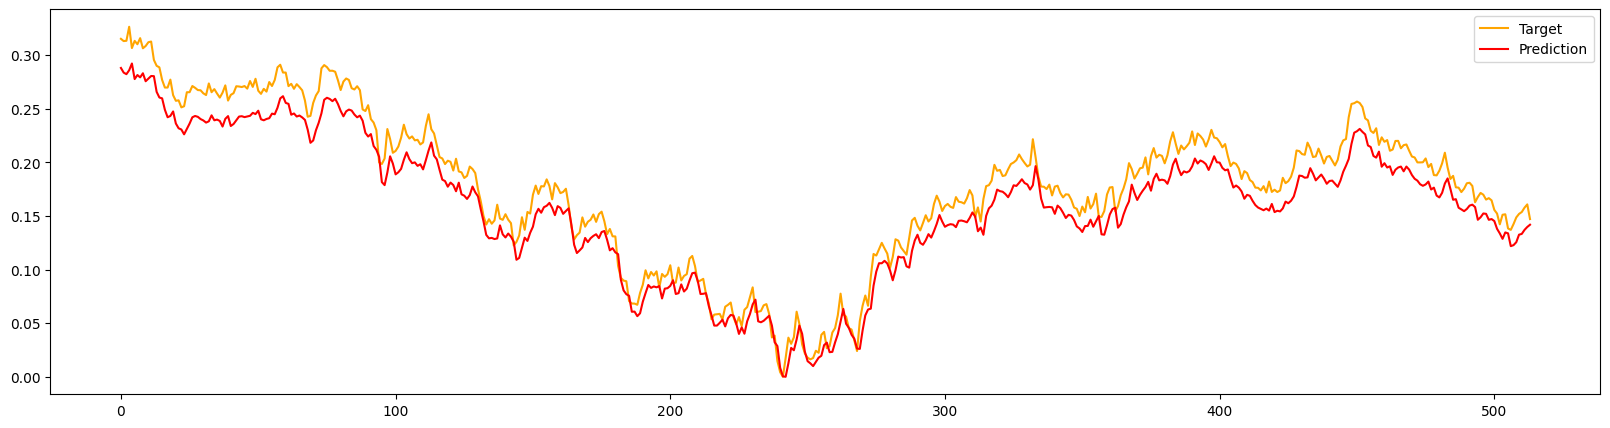

i zero...else...243
profit....102450.13610816386


In [ ]:
run_model('EURUSD=X','2000-01-01','2023-10-14',"",100)

In [ ]:
df_stock = yf.download('EURUSD=X','2000-01-01','2023-10-19')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
 data = normalize_data(df_stock)

In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,0.381761,0.372752,0.740507,0.370604,1.196501,0
2003-12-02,0.370333,0.383598,0.740639,0.389998,1.208897,0
2003-12-03,0.390533,0.386901,0.749289,0.395317,1.212298,0
2003-12-04,0.395237,0.389102,0.747109,0.388741,1.208094,0
2003-12-05,0.388658,0.396483,0.748558,0.405326,1.218695,0
...,...,...,...,...,...,...
2023-10-11,0.157948,0.151536,0.651287,0.157796,1.060479,0
2023-10-12,0.161000,0.152408,0.648197,0.160846,1.062428,0
2023-10-13,0.147291,0.139740,0.644908,0.147150,1.053674,0


In [ ]:
def future_data():
  data = {
      'Date': pd.to_datetime(['2023-10-18','2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23']),
      'Open': [0] * 6,
      'High': [0] * 6,
      'Low': [0] * 6,
      'Close': [0] * 6,
      'Adj Close': [0] * 6,
      'Volume' : [0] * 6
  }
  df_next_days = pd.DataFrame(data)
  df_next_days = df_next_days.set_index('Date')
  return df_next_days


In [ ]:
future_data = pd.DataFrame({
    'Date': pd.date_range(start='2023-10-15', periods=365, freq='D'),
    'Open': np.random.rand(365) ,
    'High': np.random.rand(365) ,
    'Low': np.random.rand(365) ,
    'Close': np.random.rand(365) ,
    'Adj Close': np.random.rand(365) ,
    'Volume' : np.random.rand(365)
})
future_data = pd.DataFrame(future_data)
future_data = future_data.set_index('Date')

In [ ]:
test_df = future_data
multi_window = WindowGenerator(test_df,input_width=n_steps,
                               label_width=1,
                               shift=1)
multi_window.test2 = multi_window.make_dataset(test_df)
predictions = feedback_model.predict(multi_window.test2)

6/6 [==============================] - 0s 8ms/step


In [ ]:
predictions

array([[[0.62622464, 0.4965584 , 0.15288989, 0.49023417, 0.10724076,
         0.        ],
        [0.49784002, 0.5537842 , 0.07765236, 0.5589802 , 0.6327953 ,
         0.03677978]],

       [[0.66203153, 0.638722  , 0.2676849 , 0.64560926, 0.614926  ,
         0.        ],
        [0.24075915, 0.23878245, 0.14516485, 0.25462407, 0.7586186 ,
         0.00377835]],

       [[0.44794235, 0.33929136, 0.4968677 , 0.27209443, 0.8247421 ,
         0.        ],
        [0.6356898 , 0.73164797, 0.37549928, 0.7767975 , 0.82893443,
         0.        ]],

       ...,

       [[0.42085207, 0.38737693, 0.40813485, 0.17239192, 0.5421666 ,
         0.        ],
        [0.40831673, 0.47801968, 0.20446381, 0.56845796, 0.56918144,
         0.13920191]],

       [[0.6420655 , 0.46952063, 0.3200224 , 0.59883124, 0.7260437 ,
         0.        ],
        [0.36468697, 0.47223517, 0.        , 0.3041935 , 0.27037627,
         0.        ]],

       [[0.4309892 , 0.4691789 , 0.24814887, 0.26137316, 0.16808257